In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Append custom library path (if you have a library to include)
import sys
custom_library_path = '/content/drive/MyDrive/your_custom_library'  # Update if you have any custom library
sys.path.append(custom_library_path)



Mounted at /content/drive


In [2]:
# Activate GPU for training
!nvidia-smi

Fri Nov  8 20:28:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision.models import resnet50
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

In [4]:
# Step 3: Paths for images and masks
covid_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/COVID19_xrays"
noncovid_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/NonCOVID19_xrays"
normal_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/Normal_xrays"

covid_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_COVID19"
noncovid_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_NonCOVID"
normal_mask_path = "/content/drive/MyDrive/extracted_files/Pre-processing data/lung_masks_Normal"

In [5]:
# Parameters
num_images = 1000
image_size = 256
batch_size = 128  # Increased batch size to better utilize GPU (!!!change to 256!!!!)
num_workers = 8  # Reduce number of workers to avoid excessive worker creation warning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load image and mask file paths
def load_image_mask_paths(image_path, mask_path, num_images):
    image_files = os.listdir(image_path)[:num_images]
    image_paths = [os.path.join(image_path, img) for img in image_files]
    mask_paths = [os.path.join(mask_path, img) for img in image_files]
    return image_paths, mask_paths


In [6]:
# Load data paths
covid_image_paths, covid_mask_paths = load_image_mask_paths(covid_path, covid_mask_path, num_images)
noncovid_image_paths, noncovid_mask_paths = load_image_mask_paths(noncovid_path, noncovid_mask_path, num_images)
normal_image_paths, normal_mask_paths = load_image_mask_paths(normal_path, normal_mask_path, num_images)

# Create labels
covid_labels = np.zeros(len(covid_image_paths))
noncovid_labels = np.ones(len(noncovid_image_paths))
normal_labels = np.full(len(normal_image_paths), 2)

# Combine data
image_paths = covid_image_paths + noncovid_image_paths + normal_image_paths
mask_paths = covid_mask_paths + noncovid_mask_paths + normal_mask_paths
labels = np.concatenate((covid_labels, noncovid_labels, normal_labels), axis=0)

In [7]:
# Split data into train, validation, and test sets
train_image_paths, test_image_paths, train_labels, test_labels, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, labels, mask_paths, test_size=0.3, random_state=42)
val_image_paths, test_image_paths, val_labels, test_labels, val_mask_paths, test_mask_paths = train_test_split(
    test_image_paths, test_labels, test_mask_paths, test_size=0.5, random_state=42)

In [8]:
# Define custom Dataset class
class XRayDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask on-the-fly
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise ValueError(f"Error loading image or mask at index {idx}")

        image = cv2.resize(image, (image_size, image_size)) / 255.0
        mask = cv2.resize(mask, (image_size, image_size)) / 255.0

        # Apply mask to the image
        image = image * mask
        image = np.stack([image, image, image], axis=-1)  # Convert to 3 channels for ResNet50

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
# Define transformations for data augmentation and normalization for training dataset
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  # Added vertical flip
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Add perspective distortion
    transforms.ElasticTransform(alpha=15.0, sigma=3.0),  # Add elastic transformation, change alpha and sigma to float
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Add Gaussian blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define transformations for validation and test datasets (no augmentation, just normalization)
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [10]:
# Create datasets and data loaders
train_dataset = XRayDataset(train_image_paths, train_mask_paths, train_labels, transform=train_transform)
val_dataset = XRayDataset(val_image_paths, val_mask_paths, val_labels, transform=val_test_transform)
test_dataset = XRayDataset(test_image_paths, test_mask_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [11]:
# Load pre-trained ResNet50 model
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),  # Increased dropout rate to reduce overfitting
    nn.BatchNorm1d(512),
    nn.Linear(512, 3)
)  # Modify the output layer for 3 classes with dropout and batch normalization
resnet50 = resnet50.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0003, weight_decay=1e-3)  # Increased weight decay for stronger regularization
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=30)  # Use OneCycleLR for optimal learning rate
reduce_lr_on_plateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)  # Reduce LR on plateau

In [13]:
# Training loop
num_epochs = 30
early_stopping_patience = 10
best_val_loss = float('inf')
early_stopping_counter = 0

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, dtype=torch.long, non_blocking=True)

        # Forward pass
        outputs = resnet50(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        nn.utils.clip_grad_norm_(resnet50.parameters(), max_norm=1.0)  # Reduced max norm for more stable training
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

    # Validation
    resnet50.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, dtype=torch.long, non_blocking=True)
            outputs = resnet50(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    train_loss_avg = running_loss / len(train_loader)
    val_loss_avg = val_loss / len(val_loader)
    train_losses.append(train_loss_avg)
    val_losses.append(val_loss_avg)

    val_accuracy = accuracy_score(val_targets, val_preds)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss_avg:.4f}, Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save(resnet50.state_dict(), 'best_resnet50_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

print("Training complete.")

Epoch [1/30], Loss: 1.0168, Validation Loss: 1.0534, Validation Accuracy: 0.5200
Epoch [2/30], Loss: 0.7209, Validation Loss: 0.9813, Validation Accuracy: 0.5067
Epoch [3/30], Loss: 0.5898, Validation Loss: 1.0879, Validation Accuracy: 0.4956
Epoch [4/30], Loss: 0.5265, Validation Loss: 0.8718, Validation Accuracy: 0.6267
Epoch [5/30], Loss: 0.5044, Validation Loss: 0.9049, Validation Accuracy: 0.6156
Epoch [6/30], Loss: 0.5196, Validation Loss: 0.9734, Validation Accuracy: 0.4422
Epoch [7/30], Loss: 0.4965, Validation Loss: 1.8254, Validation Accuracy: 0.5444
Epoch [8/30], Loss: 0.4766, Validation Loss: 0.7267, Validation Accuracy: 0.6667
Epoch [9/30], Loss: 0.5193, Validation Loss: 5.4067, Validation Accuracy: 0.5889
Epoch [10/30], Loss: 0.4751, Validation Loss: 0.7186, Validation Accuracy: 0.7022
Epoch [11/30], Loss: 0.4565, Validation Loss: 0.4326, Validation Accuracy: 0.8489
Epoch [12/30], Loss: 0.4420, Validation Loss: 0.6428, Validation Accuracy: 0.7956
Epoch [13/30], Loss: 0.45

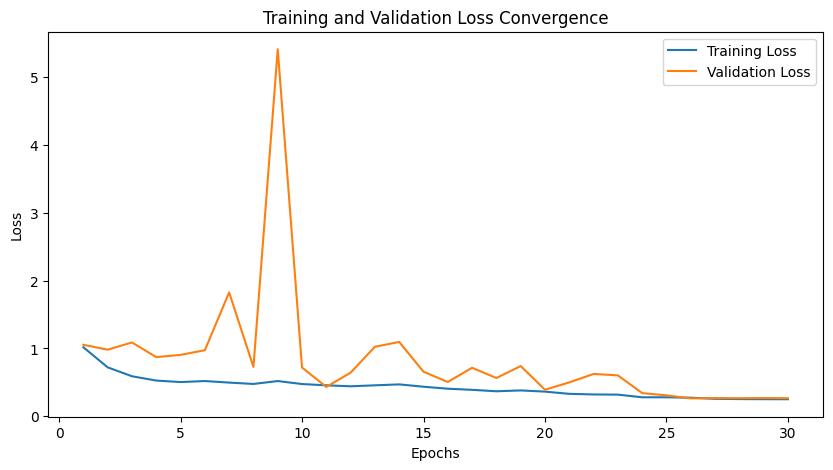

In [14]:
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Convergence')
plt.legend()
plt.show()

In [15]:
# Evaluate on test set
resnet50.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, dtype=torch.long, non_blocking=True)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(classification_report(test_targets, test_preds, target_names=['COVID', 'Non-COVID', 'Normal']))


Test Accuracy: 0.9067
Classification Report:
              precision    recall  f1-score   support

       COVID       0.96      0.83      0.89       151
   Non-COVID       0.93      0.97      0.95       152
      Normal       0.84      0.92      0.88       147

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.91      0.91      0.91       450



In [17]:
# Save the final model
model_save_path = '/content/drive/MyDrive/final_CNN_resnet50_model.pth'
torch.save(resnet50.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to /content/drive/MyDrive/final_CNN_resnet50_model.pth
